In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

import pandas as pd
from sklearn.model_selection import train_test_split

# Load dataset
df = pd.read_csv("coastal_risk_data_harder.csv")

# X = features, y = target
X = df.drop("risk_level", axis=1)   
y = df["risk_level"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Identify categorical and numerical columns
categorical_cols = X_train.select_dtypes(include=['object']).columns
numerical_cols = X_train.select_dtypes(exclude=['object']).columns

# Preprocessing: scale numeric features, encode categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ]
)

# Define models (removed LightGBM too)
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": GaussianNB(),
    "Neural Network": MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
}

results = {}

# Train and evaluate each model
for name, model in models.items():
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', model)])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc

# Create results dataframe
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Accuracy']).sort_values(by='Accuracy', ascending=False)

display(results_df)


,Accuracy
Random Forest,0.9375
SVM,0.9200
Logistic Regression,0.9075
Neural Network,0.9000
KNN,0.7850
Naive Bayes,0.2225


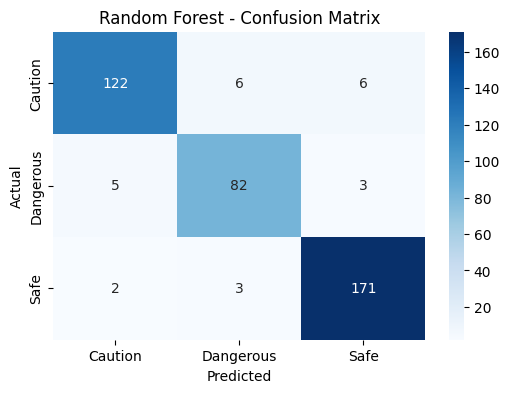

Classification Report for Random Forest:
              precision    recall  f1-score   support

     Caution       0.95      0.91      0.93       134
   Dangerous       0.90      0.91      0.91        90
        Safe       0.95      0.97      0.96       176

    accuracy                           0.94       400
   macro avg       0.93      0.93      0.93       400
weighted avg       0.94      0.94      0.94       400



In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# --- Train Random Forest separately ---
rf = Pipeline(steps=[('preprocessor', preprocessor),
                     ('classifier', RandomForestClassifier(n_estimators=200, random_state=42))])

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# --- 1. Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred, labels=rf.classes_)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.title("Random Forest - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# --- 2. Classification Report ---
print("Classification Report for Random Forest:")
print(classification_report(y_test, y_pred))


In [15]:
import joblib

# Train final model on full dataset
final_rf = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', RandomForestClassifier(n_estimators=200, random_state=42))])
final_rf.fit(X, y)

# Save the model
joblib.dump(final_rf, "random_forest_model.pkl")


['random_forest_model.pkl']

In [16]:
from sklearn.model_selection import cross_val_score
import numpy as np

cv_results = {}

# Train and evaluate each model with cross-validation
for name, model in models.items():
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', model)])
    
    # 5-fold cross validation
    scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    
    cv_results[name] = {
        "Mean Accuracy": np.mean(scores),
        "Std Dev": np.std(scores),
        "All Scores": scores
    }

# Convert results into dataframe
cv_results_df = pd.DataFrame(cv_results).T.sort_values(by="Mean Accuracy", ascending=False)

print("\nCross-Validation Results (5-fold):")
display(cv_results_df)



Cross-Validation Results (5-fold):


,Mean Accuracy,Std Dev,All Scores
Random Forest,0.949,0.012104,"[0.95, 0.9675, 0.9325, 0.955, 0.94]"
SVM,0.9365,0.014195,"[0.945, 0.9575, 0.9175, 0.9375, 0.925]"
Neural Network,0.9165,0.01437,"[0.93, 0.9375, 0.905, 0.9075, 0.9025]"
Logistic Regression,0.915,0.012145,"[0.9275, 0.925, 0.895, 0.92, 0.9075]"
KNN,0.824,0.023801,"[0.855, 0.8075, 0.79, 0.845, 0.8225]"
Naive Bayes,0.248,0.030307,"[0.225, 0.23, 0.2425, 0.3075, 0.235]"
